# RQ3: Performance validation analysis
Analyze `rq3_validation_evidence.parquet` to compare AI vs humans on performance validation evidence.

In [ ]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

# Load data
try:
    RQ3_DIR = Path(__file__).resolve().parent
except NameError:
    RQ3_DIR = Path.cwd()

out_plot = RQ3_DIR.parent / "results" / "rq3_validation_summary.png"
df = pd.read_parquet(RQ3_DIR / "rq3_validation_evidence.parquet")
print(f"Loaded {len(df)} rows")
df.head()

Loaded 407 rows


,pr_id,author_type,repo,pr_number,pr_title,pipeline_names,validation_present,evidence_sources,validation_type,validation_description,pipeline_signal,description_signal,comment_signal
0,2766896431,ai_agent,onlook-dev/onlook,982.0,Replace motion library with Tailwind transitio...,[],False,[],none,The PR description claims performance improvem...,None,Mentions performance improvement as a goal but...,Bot comment only
1,2843312341,ai_agent,promptfoo/promptfoo,3046.0,perf: optimize cache and token handling,"[CI, Validate PR Title]",False,[],none,The PR describes performance optimizations and...,"CI, Validate PR Title (generic)",Mentions performance optimizations but testing...,Bot interactions and unit test generation status
2,2843334531,ai_agent,promptfoo/promptfoo,3047.0,perf: optimize cache and token handling,"[CI, Validate PR Title]",False,[],none,The PR description claims performance optimiza...,"CI, Validate PR Title (no perf workflows)",Mentions performance optimizations but lists o...,Bot interactions only
3,2855302194,ai_agent,pdfme/pdfme,711.0,Optimize Font Loading Performance in Tests,[Unit Testing],True,[description],benchmark,Description provides explicit 'Before' and 'Af...,Unit Testing,Performance Improvements section lists specifi...,Automated bot comments only
4,2859989652,ai_agent,wolfSSL/wolfssh,779.0,Update SFTP status callback to output once per...,"[Cppcheck Test, Kyber Tests, OS Check Test, Si...",False,[],none,No validation evidence,Static analysis and functional tests (Cppcheck...,Verified using cppcheck; mentions reducing sta...,User mentions fixing a bottleneck and requests...


In [ ]:
print("Rows:", len(df))
print("Authors:", df["author_type"].value_counts().to_dict())
print("validation_present counts:", df["validation_present"].value_counts(dropna=False))
print("validation_type counts:", df["validation_type"].value_counts(dropna=False))

Rows: 407
Authors: {'ai_agent': 324, 'human': 83}
validation_present counts: validation_present
False    281
True     122
None       4
Name: count, dtype: int64
validation_type counts: validation_type
none           267
benchmark       77
profiling       24
unspecified     17
unit-only       15
error            4
load/canary      3
Name: count, dtype: int64


In [ ]:
perf_types = {"benchmark", "profiling", "load/canary"}
df["is_perf_validation"] = df["validation_type"].isin(perf_types)

val_present = df.pivot_table(index="author_type", columns="validation_present", aggfunc="size", fill_value=0)
val_present["total"] = val_present.sum(axis=1)
val_present["pct_true"] = (val_present.get(True, 0) / val_present["total"] * 100).round(1)
print("Validation present counts and %true:", val_present)

vt = df.groupby(["author_type", "validation_type"]).size().unstack(fill_value=0)
vt_pct = vt.div(vt.sum(axis=1), axis=0).round(3)
print("Validation type counts:", vt)
print("Validation type share:", vt_pct)

perf_rates = df.groupby("author_type")["is_perf_validation"].mean().mul(100).round(1)
print("Perf-oriented validation rate (% benchmark/profiling/load-canary):", perf_rates)

Validation present counts and %true: validation_present  False  True  total  pct_true
author_type                                     
ai_agent              239    81    320      25.3
human                  42    41     83      49.4
Validation type counts: validation_type  benchmark  error  load/canary  none  profiling  unit-only  \
author_type                                                                  
ai_agent                50      4            1   225         20         15   
human                   27      0            2    42          4          0   

validation_type  unspecified  
author_type                   
ai_agent                   9  
human                      8  
Validation type share: validation_type  benchmark  error  load/canary   none  profiling  unit-only  \
author_type                                                                   
ai_agent             0.154  0.012        0.003  0.694      0.062      0.046   
human                0.325  0.000        0.024

In [ ]:
exploded = df.explode("evidence_sources")
source_counts = exploded.groupby(["author_type", "evidence_sources"]).size().unstack(fill_value=0)
denom = exploded.groupby("author_type").size()
source_pct = (source_counts.div(denom, axis=0) * 100).round(1)
print("Evidence source counts:", source_counts)
print("Evidence source % of PRs mentioning source:", source_pct)

Evidence source counts: evidence_sources  comments  description  pipeline
author_type                                      
ai_agent                14           85        10
human                   19           38         4
Evidence source % of PRs mentioning source: evidence_sources  comments  description  pipeline
author_type                                      
ai_agent               4.1         24.7       2.9
human                 18.6         37.3       3.9


Saved plot to /Users/antoniozhong/Documents/dev/purdue/MSR2026/github_perf_patch_study/results/rq3_validation_summary.png


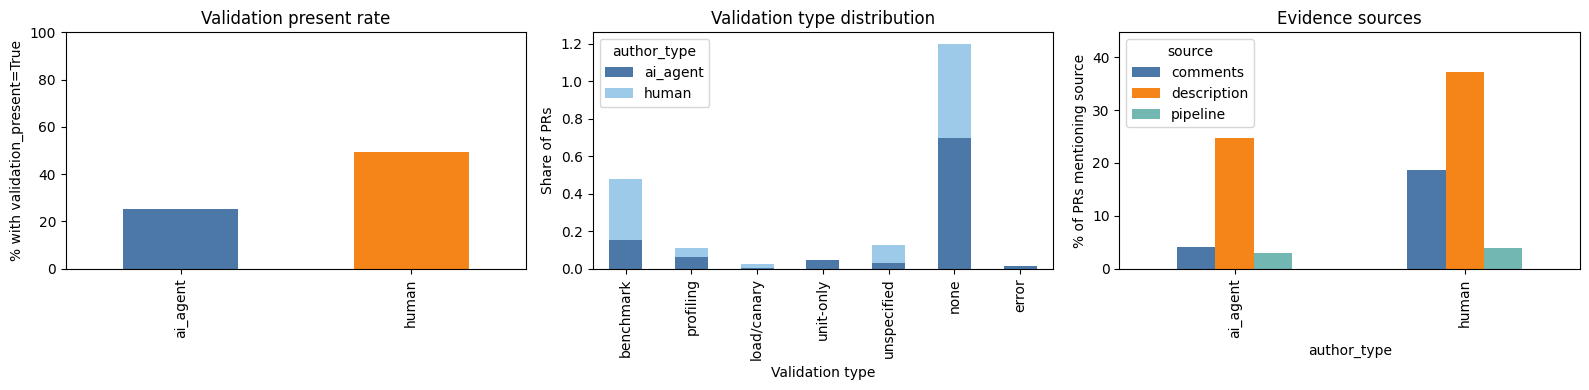

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

present = df.pivot_table(index="author_type", columns="validation_present", aggfunc="size", fill_value=0)
present_pct = (present.get(True, 0) / present.sum(axis=1) * 100)
present_pct.plot(kind="bar", ax=axes[0], color=["#4c78a8", "#f58518"])
axes[0].set_ylabel("% with validation_present=True")
axes[0].set_xlabel("")
axes[0].set_title("Validation present rate")
axes[0].set_ylim(0, 100)

vt = df.groupby(["author_type", "validation_type"]).size().unstack(fill_value=0)
vt_pct = vt.div(vt.sum(axis=1), axis=0)
order = ["benchmark", "profiling", "load/canary", "unit-only", "unspecified", "none", "error"]
for col in order:
    if col not in vt_pct.columns:
        vt_pct[col] = 0
vt_pct = vt_pct[order]
vt_pct.T.plot(kind="bar", stacked=True, ax=axes[1], color=["#4c78a8", "#9ecae9", "#54a24b", "#b079a7", "#e45756", "#bab0ac", "#ff9da6"])
axes[1].set_ylabel("Share of PRs")
axes[1].set_xlabel("Validation type")
axes[1].set_title("Validation type distribution")
axes[1].legend(title="author_type")

exploded = df.explode("evidence_sources")
source_counts = exploded.groupby(["author_type", "evidence_sources"]).size().unstack(fill_value=0)
denom = exploded.groupby("author_type").size()
source_pct = (source_counts.div(denom, axis=0) * 100)
source_pct.plot(kind="bar", ax=axes[2], color=["#4c78a8", "#f58518", "#72b7b2"])
axes[2].set_ylabel("% of PRs mentioning source")
axes[2].set_xlabel("author_type")
axes[2].set_title("Evidence sources")
axes[2].legend(title="source")
axes[2].set_ylim(0, max(source_pct.max()) * 1.2 if len(source_pct) else 1)

fig.tight_layout()
out_plot.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(out_plot, dpi=200)
print(f"Saved plot to {out_plot}")
plt.show()